# Experiments for the traffic accident occurrence prediction task

In [1]:
import os
import math
import shutil
import pickle
import numpy as np
import osmnx as ox
import pandas as pd
import os.path as osp
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from torch import Tensor
from torch.nn import Parameter
from torch_geometric.io import read_npz
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset, uniform, zeros
from torch_geometric.typing import OptTensor, OptPairTensor, Adj, Size
from torch_geometric.data import Data, DataLoader, InMemoryDataset, download_url

from pylab import cm
from matplotlib import colors
from IPython.display import clear_output
from xgboost.sklearn import XGBClassifier
from typing import Union, Tuple, Callable, Optional
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

np.random.seed(7)
torch.manual_seed(7)
plt.style.use("ggplot")

## Define functions

In [2]:
def train_test_split_stratify(dataset, train_ratio, val_ratio, class_num):
    labels = dataset[0].y
    train_mask = torch.zeros(size=labels.shape, dtype=bool)
    val_mask = torch.zeros(size=labels.shape, dtype=bool)
    test_mask = torch.zeros(size=labels.shape, dtype=bool)
    for i in range(class_num):
        stratify_idx = np.argwhere(labels.numpy() == i).flatten()
        np.random.shuffle(stratify_idx)
        split1 = int(len(stratify_idx) * train_ratio)
        split2 = split1 + int(len(stratify_idx) * val_ratio)
        train_mask[stratify_idx[:split1]] = True 
        val_mask[stratify_idx[split1:split2]] = True
        test_mask[stratify_idx[split2:]] = True
#     print("Sanity check of train_test_split:", train_mask.sum(), "+", val_mask.sum(), "+", test_mask.sum(), "=", len(labels))
    
    highest = pd.DataFrame(data.y).value_counts().head().iloc[0]
    print("Null Accuracy:", highest / (len(data.y)))
    return train_mask, val_mask, test_mask

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

    
@torch.no_grad()
def test(model, data):
    model.eval()
    logits, measures = model().detach(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        mea = f1_score(data.y[mask], pred, average='binary')
        measures.append(mea)
    label_pred = logits.max(1)[1]

    mask = data.test_mask
    scores = logits[mask][:,1]
    pred = logits[mask].max(1)[1]
    test_y = data.y[mask]
    
    test_acc = pred.eq(test_y).sum().item() / mask.sum().item()
    test_map = average_precision_score(test_y, scores)
    test_auc = roc_auc_score(test_y, scores)
    return measures, label_pred, test_acc, test_map, test_auc


def train_loop(model, data, optimizer, num_epochs):
    epochs, train_measures, valid_measures, test_measures, test_accs, test_maps, test_aucs = [], [], [], [], [], [], []
    for epoch in range(num_epochs):
        train(model, data, optimizer)
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        measures, label_pred, test_acc, test_map, test_auc = test(model, data)
        train_mea, valid_mea, test_mea = measures
        epochs.append(epoch)
        train_measures.append(train_mea)
        valid_measures.append(valid_mea)
        test_measures.append(test_mea)
        test_accs.append(test_acc)
        test_maps.append(test_map)
        test_aucs.append(test_auc)
        
        if epoch % 20 == 0:
            clear_output(True)
            fig, (ax1, ax) = plt.subplots(1, 2, figsize=(30, 12))     
            gdf_pred.label = label_pred.numpy()
            for i in range(class_num):
                G = nx.MultiGraph()
                G.add_nodes_from(gdf_pred[gdf_pred['label'] == i].index)
                sub1 = nx.draw(G, pos=pos_dict, ax=ax1, node_color=color_ls[i], node_size=10, edge_color='grey', width=0.6)

            ax.text(1, 1, log.format(epoch, train_measures[-1], valid_measures[-1], test_measures[-1]), fontsize=18)
            ax.plot(epochs, train_measures, "r", epochs, valid_measures, "g", epochs, test_measures, "b")
            ax.set_ylim([0, 1])
            ax.legend(["train", "valid", "test"])  
            ax1.legend(["Negative", "Positive"])  
            plt.show()

    # Select idx from the second half period where the scores are more stable
    select_idx = np.argmax(valid_measures[num_epochs//2:]) + num_epochs//2  # test_measures
    final_test_mea = np.array(test_measures)[select_idx]
    final_test_acc = np.array(test_accs)[select_idx]
    final_test_map = np.array(test_maps)[select_idx]
    final_test_auc = np.array(test_aucs)[select_idx]

    print('Selected epoch {}'.format(select_idx))
    print('F measure {:.5f} | Test Accuracy {:.5f} | MAP {:.5f} | AUC {:.5f}'.format(final_test_mea, final_test_acc, final_test_map, final_test_auc))
    return (final_test_mea, final_test_acc, final_test_map, final_test_auc)

In [4]:
def read_npz(path):
    with np.load(path) as f:
        return parse_npz(f)


def parse_npz(f):
    x = torch.from_numpy(f['x']).to(torch.float)
    y = torch.from_numpy(f['y']).to(torch.long)
    edge_attr = torch.from_numpy(f['edge_attr']).to(torch.float)
    edge_index = torch.from_numpy(f['edge_index']).to(torch.long).t().contiguous()
    edge_attr_dir = torch.from_numpy(f['edge_attr_dir']).to(torch.float)
    edge_attr_ang = torch.from_numpy(f['edge_attr_ang']).to(torch.float)
    coords = torch.from_numpy(f['coordinates']).to(torch.float)
    severity_labels = torch.from_numpy(f['severity_labels']).to(torch.long)
    return Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, edge_attr_dir=edge_attr_dir,
                edge_attr_ang=edge_attr_ang, coords=coords, severity_labels=severity_labels)

In [9]:
class TRAVELDataset(InMemoryDataset):
    r"""The TRAVEL datasets from the
    `"TRAVEL: Traffic Accident Prediction using Graph Neural Networks" <https://link>`_ paper.
    Nodes represent intersections or dead-end nodes and edges represent roads.
    Datasets include 'houston', 'charlotte', 'dallas', 'austin'.

    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset (:obj:`"houston"`, :obj:`"charlotte"`
            :obj:`"dallas"`, :obj:`"austin"`).
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """
    
    url = 'https://github.com/baixianghuang/travel/raw/main/dataset/{}.npz'

    def __init__(self, root: str, name: str,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.name = name.lower()
        assert self.name in ['houston', 'charlotte', 'dallas', 'austin']
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        download_url(self.url.format(self.name), self.raw_dir)

    def process(self):
        data = read_npz(self.raw_paths[0])
        data = data if self.pre_transform is None else self.pre_transform(data)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}Full()'

## Load and preprocess data

In [10]:
place_names = {
    'houston': {"city": "Houston", "state": "Texas"},
    'charlotte': {"city": "Charlotte", "state": "North Carolina"},
    'dallas': {"city": "Dallas", "state": "Texas"},
    'austin': {"city": "Austin", "state": "Texas"},
}
city_name = 'dallas'


In [11]:
if os.path.exists('dataset/'+city_name+'/processed'):
    shutil.rmtree('dataset/'+city_name+'/processed')

dataset_city = TRAVELDataset('dataset', city_name)
dataset = dataset_city
data = dataset_city[0]
class_num = dataset.num_classes

print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
data

Processing...
Done!
Number of graphs: 1
Number of node features: 10
Number of edge features: 17
Number of classes: 2
Number of nodes: 36036
Number of edges: 92271
Average node degree: 2.56
Contains isolated nodes: False
Contains self-loops: True
Is undirected: False


Data(coords=[36036, 2], edge_attr=[92271, 17], edge_attr_ang=[92271, 3], edge_attr_dir=[92271, 2], edge_index=[2, 92271], severity_labels=[36036], x=[36036, 10], y=[36036])

In [12]:
# 60%, 20% and 20% for training, validation and test
data.train_mask, data.val_mask, data.test_mask = train_test_split_stratify(dataset_city, train_ratio=0.6, val_ratio=0.2, class_num=class_num)

sc = StandardScaler()
data.x[data.train_mask] = torch.tensor(sc.fit_transform(data.x[data.train_mask]), dtype=torch.float)
data.x[data.val_mask] = torch.tensor(sc.transform(data.x[data.val_mask]), dtype=torch.float)
data.x[data.test_mask] = torch.tensor(sc.transform(data.x[data.test_mask]), dtype=torch.float)

Null Accuracy: 0.6962204462204462


In [13]:
edge_attr1 = np.concatenate((data.edge_attr, data.edge_attr_dir), axis=1) # directional component
edge_attr2 = np.concatenate((data.edge_attr, data.edge_attr_ang), axis=1) # angular component
edge_attr1 = StandardScaler().fit_transform(edge_attr1)
edge_attr2 = StandardScaler().fit_transform(edge_attr2)
data.edge_attr1 = torch.tensor(edge_attr1).float()
data.edge_attr2 = torch.tensor(edge_attr2).float()
num_edge_features1 = data.edge_attr1.shape[1]
num_edge_features2 = data.edge_attr2.shape[1]

edge_attr2

array([[ 4.456922  ,  7.641073  ,  0.6998903 , ..., -2.2491739 ,
        -1.4029166 ,  2.921994  ],
       [ 2.0099242 ,  7.641073  ,  2.7955754 , ...,  1.5088423 ,
         3.028726  ,  2.921994  ],
       [ 2.7323506 ,  7.641073  ,  2.7955754 , ..., -2.892147  ,
        -2.1611433 , -1.9135829 ],
       ...,
       [ 1.6247852 , -0.1310216 , -0.3479522 , ...,  0.56703645,
        -0.27593285,  1.0645379 ],
       [-0.72519207, -0.1310216 , -0.3479522 , ..., -1.6359322 ,
        -0.679751  ,  1.7300973 ],
       [-0.5620153 , -0.1310216 ,  1.7477328 , ...,  0.8956007 ,
         2.3055604 ,  1.7300973 ]], dtype=float32)

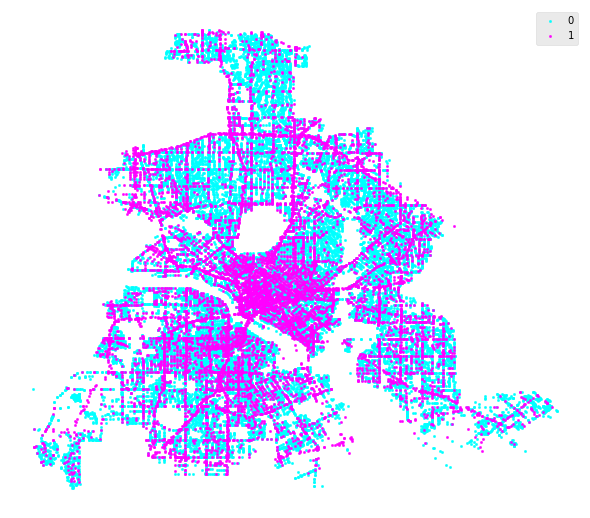

In [14]:
def draw_with_labels(gdf_nodes, cmap):
    # Note that the order of coordinates should be (Lng, Lat)
    plt.figure(figsize=(8, 7)) 
    df_ls = []  # df with different labels
    for i in range(class_num):
        G = nx.MultiGraph()
        G.add_nodes_from(gdf_nodes[gdf_nodes['label'] == i].index)
        nx.draw(G, pos=pos_dict, node_color=cmap[i], node_size=5, edge_color='grey', width=0.6, label=i)
    plt.legend(loc="upper right")
    plt.show()


# Prepare colormap: plasma, bwr, Reds, hot
color_ls = []
cmap = cm.get_cmap('cool', class_num)
for i in range(class_num):
    rgba = cmap(i)   
    color_ls.append(colors.rgb2hex(rgba))

coords = data.coords.numpy()
gdf_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1]}) 
zip_iterator = zip(gdf_pred.index, gdf_pred[['x', 'y']].values)
pos_dict = dict(zip_iterator)
gdf_pred['label'] = data.y.numpy()
draw_with_labels(gdf_pred, color_ls)  # Ground truth

## Training

In [15]:
d = 32 # number of hidden units
all_res = []
num_epochs = 201
data = data.to(device)

In [16]:
X_train, X_test, y_train, y_test = data.x[data.train_mask].numpy(), data.x[data.test_mask].numpy(), data.y[data.train_mask].numpy(), data.y[data.test_mask].numpy()
xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
test_acc, test_f1, test_map, test_auc = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='binary'), average_precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)
print('Test Accuracy {:.5f} | f1_score {:.5f} | MAP {:.5f} | AUC {:.5f}'.format(test_acc, test_f1, test_map, test_auc))
res = (test_f1, test_acc, test_map, test_auc)
all_res.append(('XGBoost',) + res)

[19:58:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Accuracy 0.73921 | f1_score 0.31537 | MAP 0.39770 | AUC 0.58661


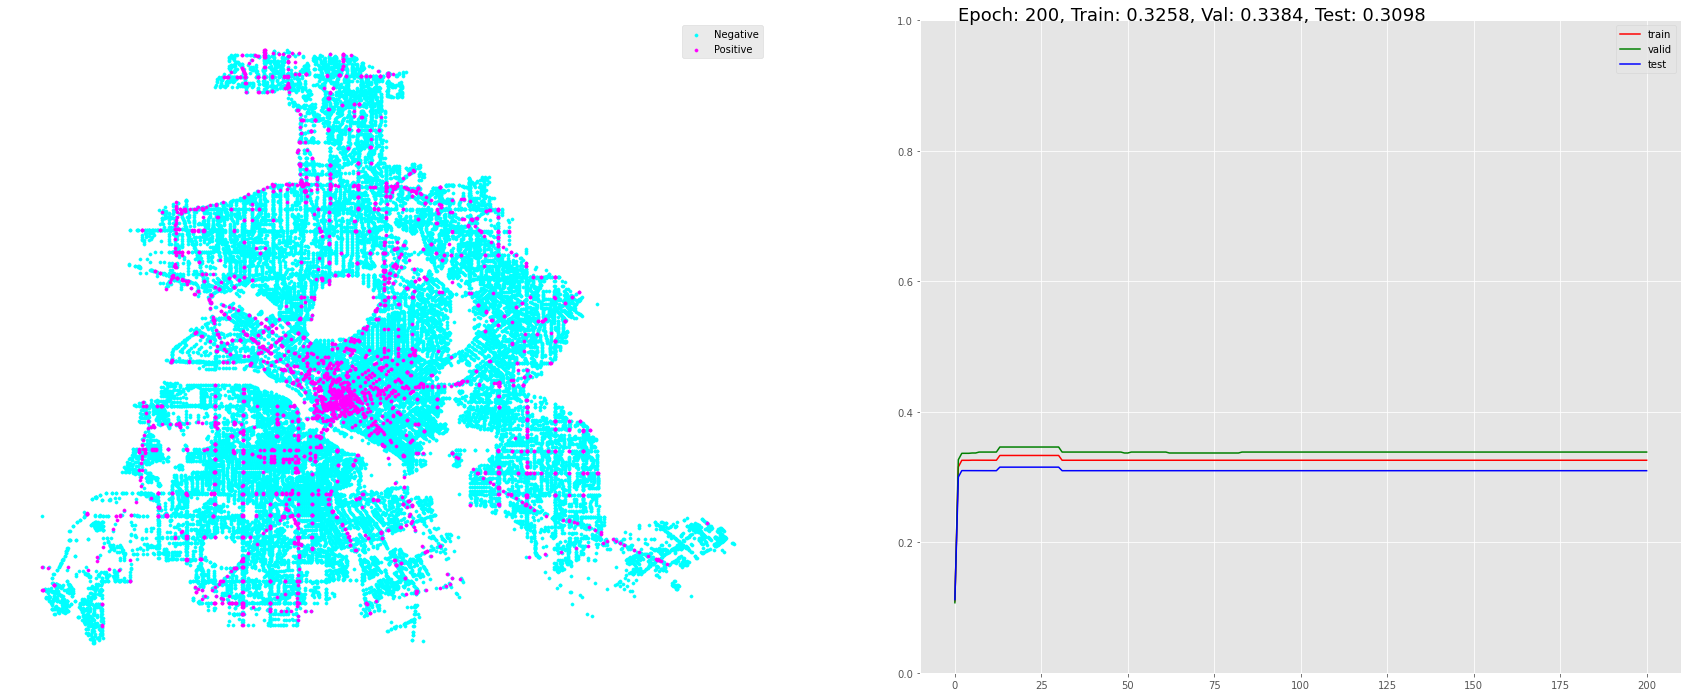

Selected epoch 100
F measure 0.30984 | Test Accuracy 0.73921 | MAP 0.47588 | AUC 0.68321


In [17]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=d):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dataset.num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x = F.relu(self.fc1(data.x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = MLP().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('MLP',) + res)

### Among GNN baselines, GraphSAGE and GAT frameworks do not support message passing with edge features.

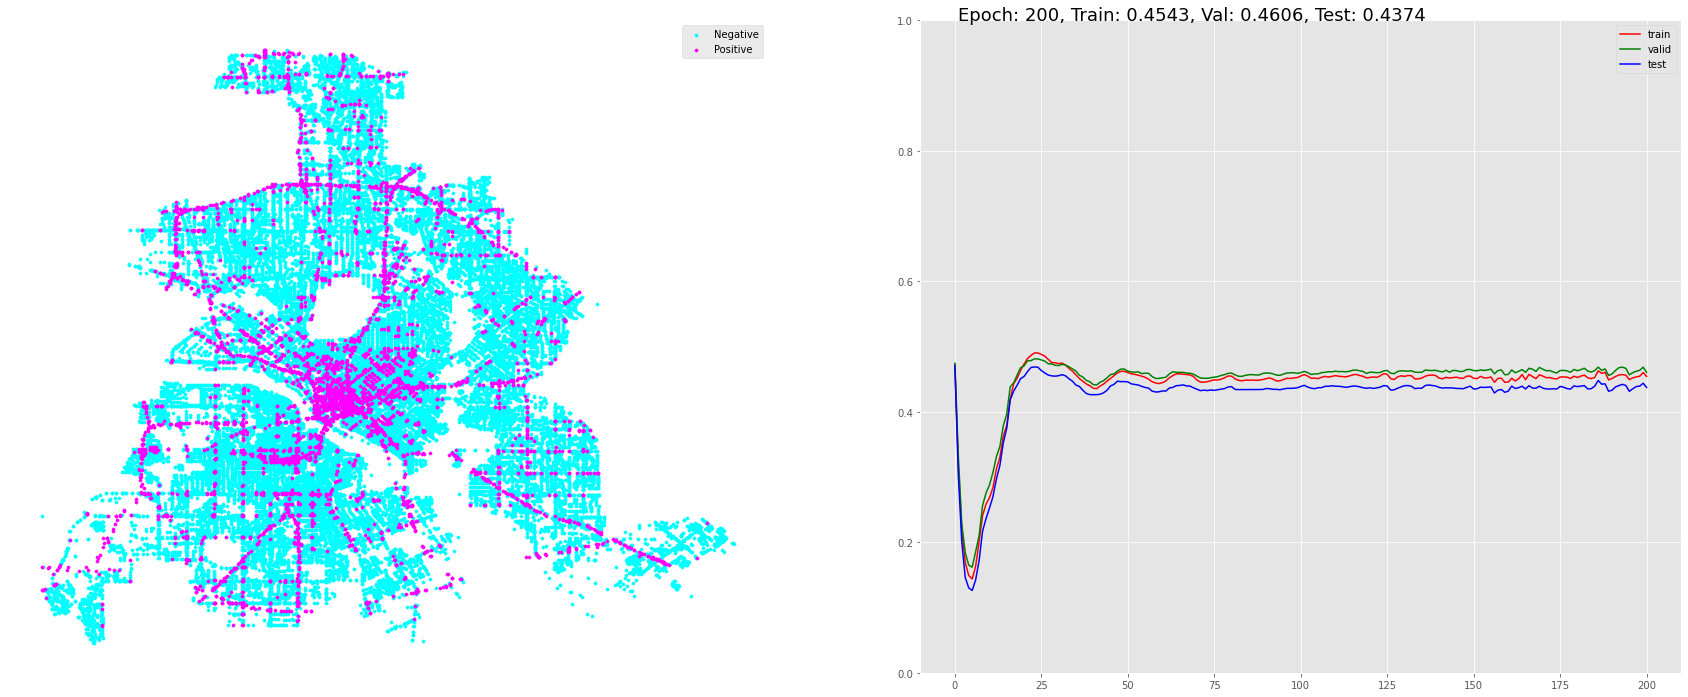

Selected epoch 186
F measure 0.44816 | Test Accuracy 0.75711 | MAP 0.60665 | AUC 0.75678


In [18]:
class SAGENet(torch.nn.Module):
    def __init__(self, dim=d):
        super(SAGENet, self).__init__()
        self.conv1 = pyg_nn.SAGEConv(dataset.num_features, dim)
        self.conv2 = pyg_nn.SAGEConv(dim, dim*2, normalize=True)
        self.fc1 = nn.Linear(dim*2, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


model = SAGENet().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('SAGENet',) + res)

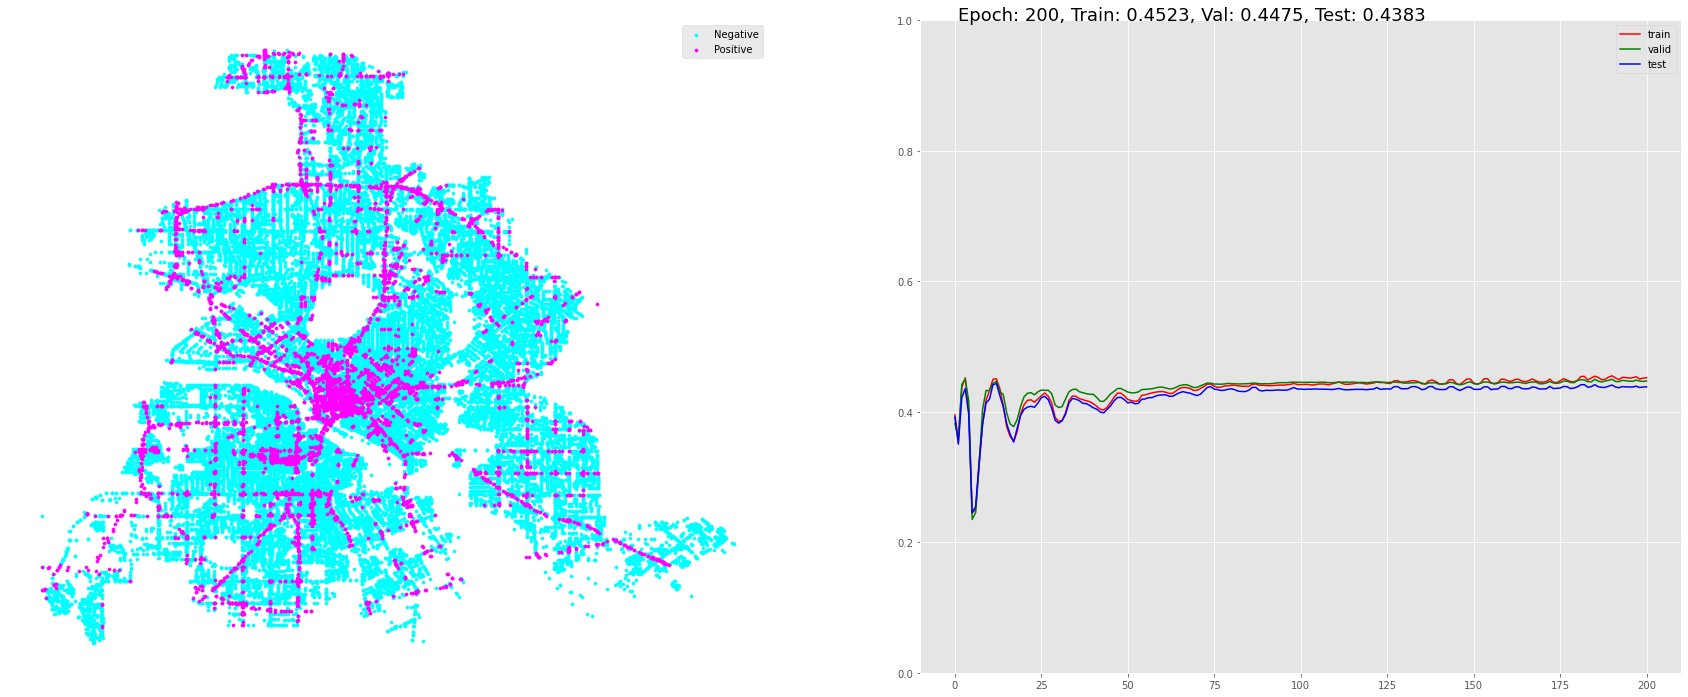

Selected epoch 185
F measure 0.44163 | Test Accuracy 0.74920 | MAP 0.57284 | AUC 0.73135


In [19]:
class GAT(torch.nn.Module):
    def __init__(self, dim=d):
        super(GAT, self).__init__()
        self.conv1 = pyg_nn.GATConv(dataset.num_features, dim, heads=dim) 
        self.conv2 = pyg_nn.GATConv(dim * dim, dataset.num_classes, heads=1, concat=False) 

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)
    
model = GAT().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('GAT',) + res)

### MPNN, GMM, GINE, and TRAVEL frameworks support message passing with multi-dimensional edge features

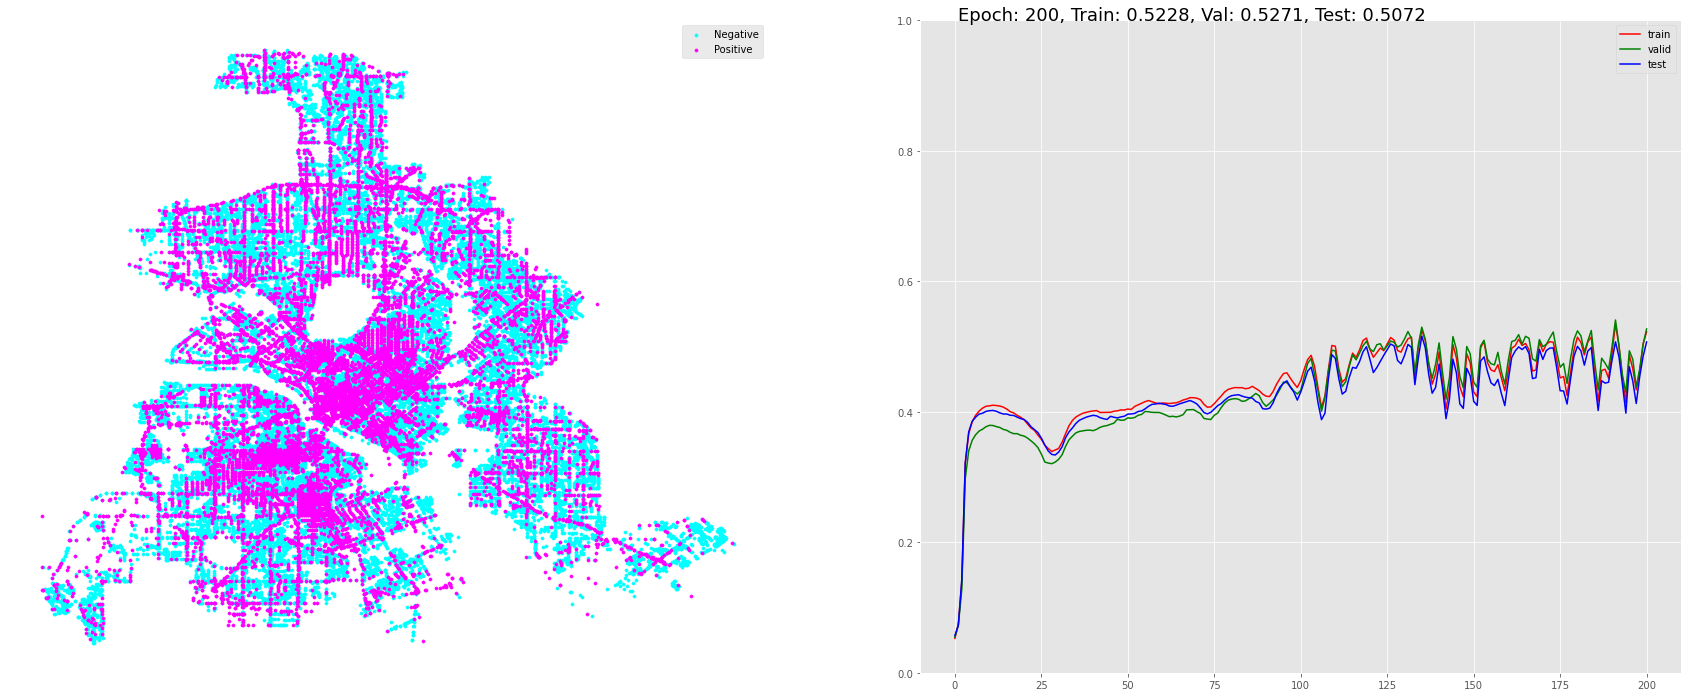

Selected epoch 191
F measure 0.50738 | Test Accuracy 0.68054 | MAP 0.51922 | AUC 0.69396


In [20]:
class MPNN(torch.nn.Module):
    def __init__(self, dim=d):
        super(MPNN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(dataset.num_edge_features, 16), nn.ReLU(), nn.Linear(16, dataset.num_features*dim))
        self.conv1 = pyg_nn.NNConv(dataset.num_features, dim, nn1)
        nn2 = nn.Sequential(nn.Linear(dataset.num_edge_features, 16), nn.ReLU(), nn.Linear(16, dataset.num_classes*dim))
        self.conv2 = pyg_nn.NNConv(dim, dataset.num_classes, nn2)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.5, training=self.training)
        x = (self.conv2(x, edge_index, edge_weight))
        return F.log_softmax(x, dim=1)


model = MPNN().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('MPNN',) + res)

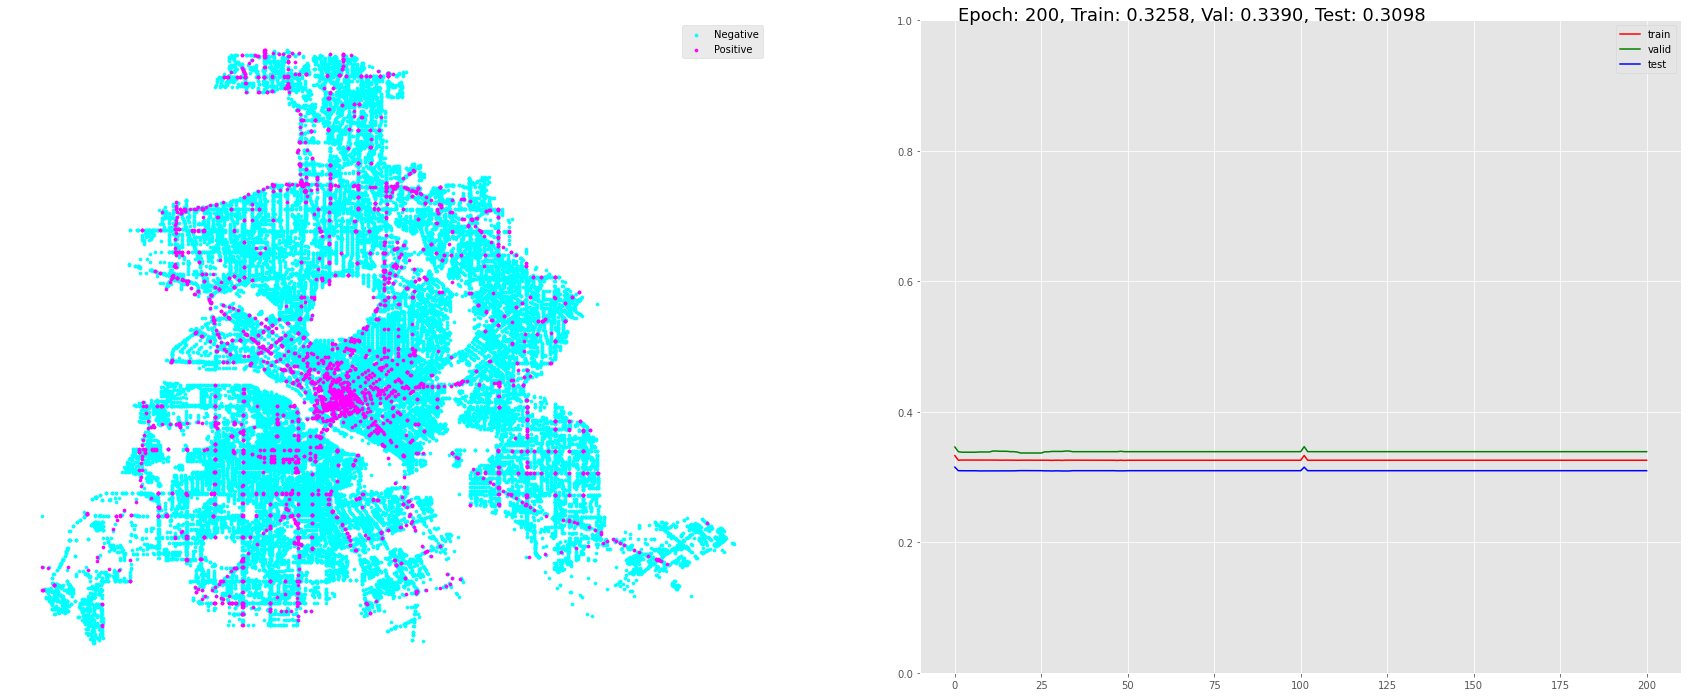

Selected epoch 101
F measure 0.31525 | Test Accuracy 0.73908 | MAP 0.47585 | AUC 0.68312


In [21]:
class GMMNet(torch.nn.Module):
    def __init__(self, hidden=d):
        super(GMMNet, self).__init__()
        self.conv1 = pyg_nn.GMMConv(dataset.num_features, hidden//2, dim=data.edge_attr.shape[1], kernel_size=5) 
        self.conv2 = pyg_nn.GMMConv(hidden//2, hidden, dim=data.edge_attr.shape[1], kernel_size=5)
        self.fc1 = nn.Linear(hidden, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = GMMNet().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('GMMNet',) + res)

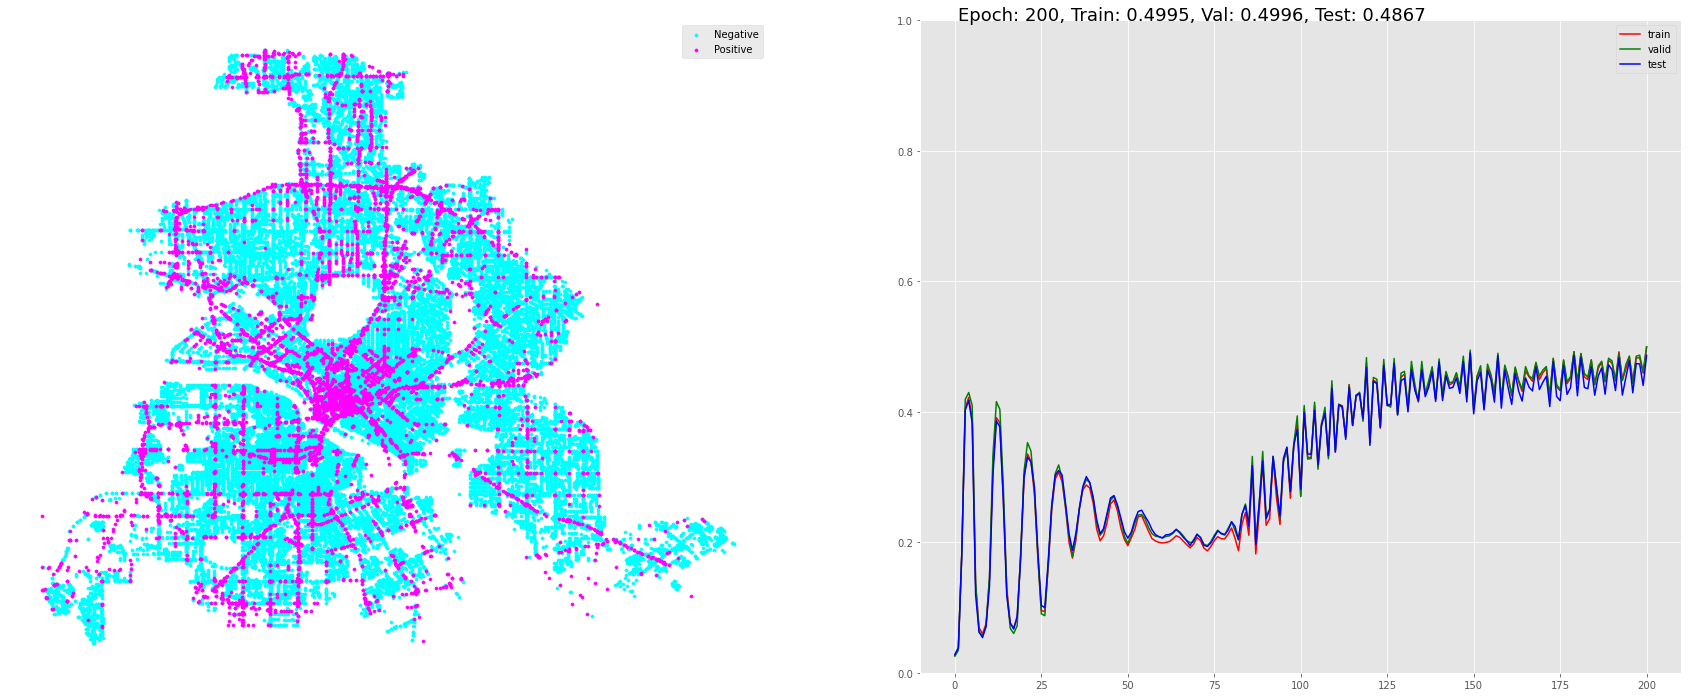

Selected epoch 200
F measure 0.48667 | Test Accuracy 0.75156 | MAP 0.60841 | AUC 0.76163


In [22]:
class GINE(torch.nn.Module):
    def __init__(self, dim=d):
        super(GINE, self).__init__()
        nn1 = nn.Sequential(nn.Linear(dataset.num_features, dim), nn.ReLU(), nn.Linear(dim, dataset.num_edge_features))
        self.conv1 = pyg_nn.GINEConv(nn1)  # , train_eps=True
        nn2 = nn.Sequential(nn.Linear(dataset.num_edge_features, dim), nn.ReLU(), nn.Linear(dim, dim))
        self.conv2 = pyg_nn.GINEConv(nn2)
        self.fc1 = nn.Linear(dim, dataset.num_classes)
        self.fc_edge_attr = nn.Linear(dataset.num_edge_features, dataset.num_features)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, self.fc_edge_attr(edge_weight)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


model = GINE().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('GINE',) + res)

In [23]:
class TRAVELConv(MessagePassing):
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, nn: Callable, aggr: str = 'add',
                 root_weight: bool = True, bias: bool = True, **kwargs):
        super(TRAVELConv, self).__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
            
        self.in_channels_l = in_channels[0]

        if root_weight:
            self.root = Parameter(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        if self.root is not None:
            uniform(self.root.size(0), self.root)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None and self.root is not None:
            out += torch.matmul(x_r, self.root)

        if self.bias is not None:
            out += self.bias
        return out


    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: Tensor) -> Tensor:
# tensors passed to propagate() can be mapped to the respective nodes by appending _i or _j to the variable name        
        inputs = torch.cat([x_j, edge_attr], dim=1)
        return self.nn(inputs)

    def __repr__(self):
        return '{}({}, {}, aggr="{}", nn={})'.format(self.__class__.__name__,
                                                     self.in_channels,
                                                     self.out_channels,
                                                     self.aggr, self.nn)

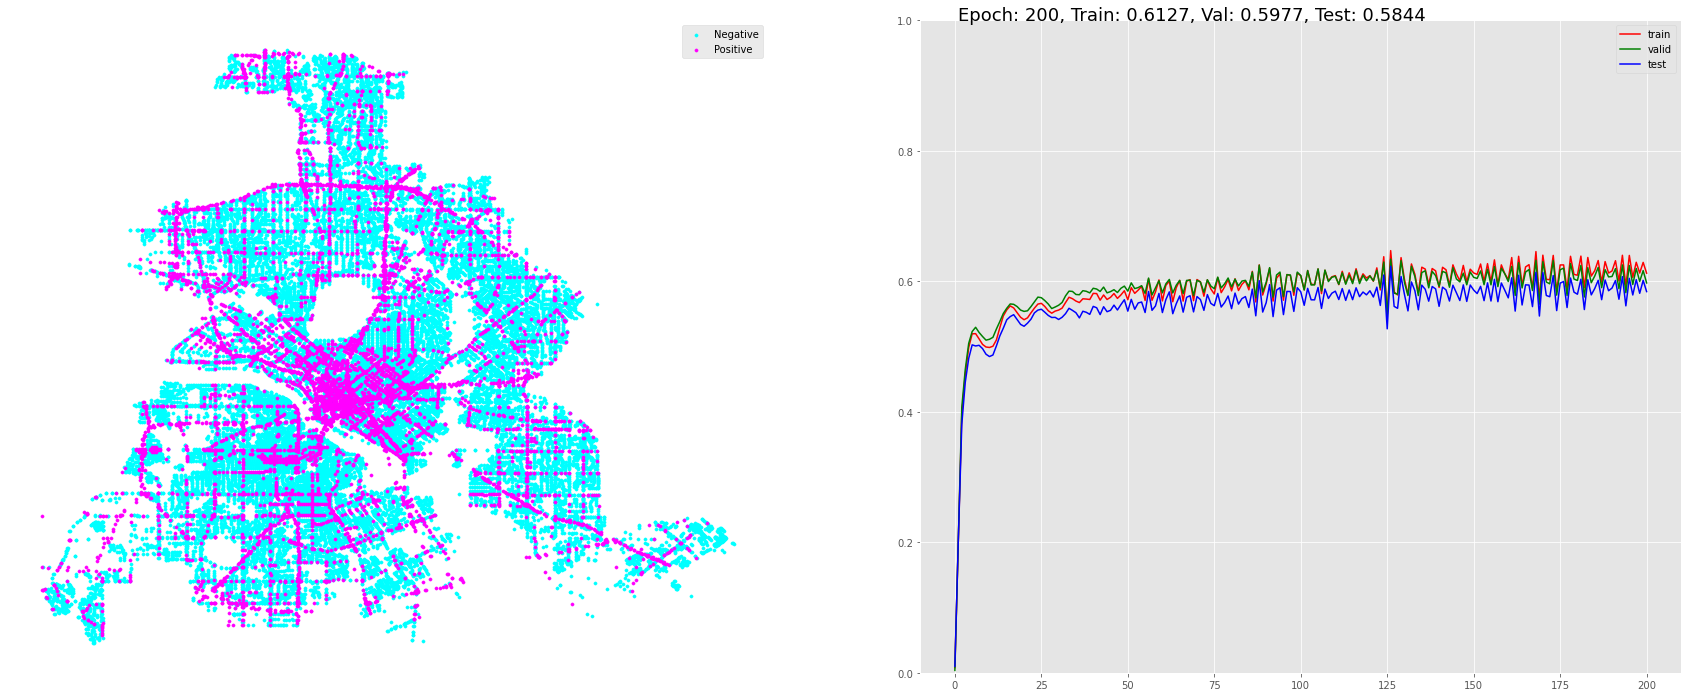

Selected epoch 126
F measure 0.62323 | Test Accuracy 0.78263 | MAP 0.68946 | AUC 0.82334


In [24]:
class TRAVELNet(torch.nn.Module):
    def __init__(self, dim=32):
        super(TRAVELNet, self).__init__()
        convdim = 8
        nn1 = nn.Sequential(nn.Linear(dataset.num_features + num_edge_features1, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1 = TRAVELConv(dataset.num_features, convdim, nn1)
        nn2 = nn.Sequential(nn.Linear(2*convdim + num_edge_features1, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2 = TRAVELConv(2*convdim, dataset.num_classes, nn2)

        nn1_2 = nn.Sequential(nn.Linear(dataset.num_features + num_edge_features2, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1_2 = TRAVELConv(dataset.num_features, convdim, nn1_2)
        nn2_2 = nn.Sequential(nn.Linear(2*convdim + num_edge_features2, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2_2 = TRAVELConv(2*convdim, dataset.num_classes, nn2_2)
        self.fc = nn.Linear(dataset.num_classes*2, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_weight1, edge_weight2 = data.x, data.edge_index, data.edge_attr1, data.edge_attr2
        x1 = F.relu(self.conv1(x, edge_index, edge_weight1))
        x2 = F.relu(self.conv1_2(x, edge_index, edge_weight2))
        x = torch.cat((x1, x2), axis=1)
        x = F.dropout(x, p=0.5, training=self.training)
        x1 = self.conv2(x, edge_index, edge_weight1)
        x2 = self.conv2_2(x, edge_index, edge_weight2)
        x = torch.cat((x1, x2), axis=1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


model = TRAVELNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('TRAVEL',) + res)

In [25]:
results = pd.DataFrame(all_res, columns=['Method', 'F1', 'Accuracy', 'MAP', 'AUC'])
results

,Method,F1,Accuracy,MAP,AUC
0,XGBoost,0.315368,0.739215,0.397700,0.586605
1,MLP,0.309838,0.739215,0.475876,0.683208
2,SAGENet,0.448156,0.757109,0.606645,0.756776
3,GAT,0.441631,0.749202,0.572841,0.731355
4,MPNN,0.507380,0.680538,0.519221,0.693958
5,GMMNet,0.315253,0.739076,0.475853,0.683119
6,GINE,0.486672,0.751561,0.608408,0.761628
7,TRAVEL,0.623227,0.782633,0.689456,0.823338


### GCNs and ChebNets only support message passing with one-dimensional edge attribute

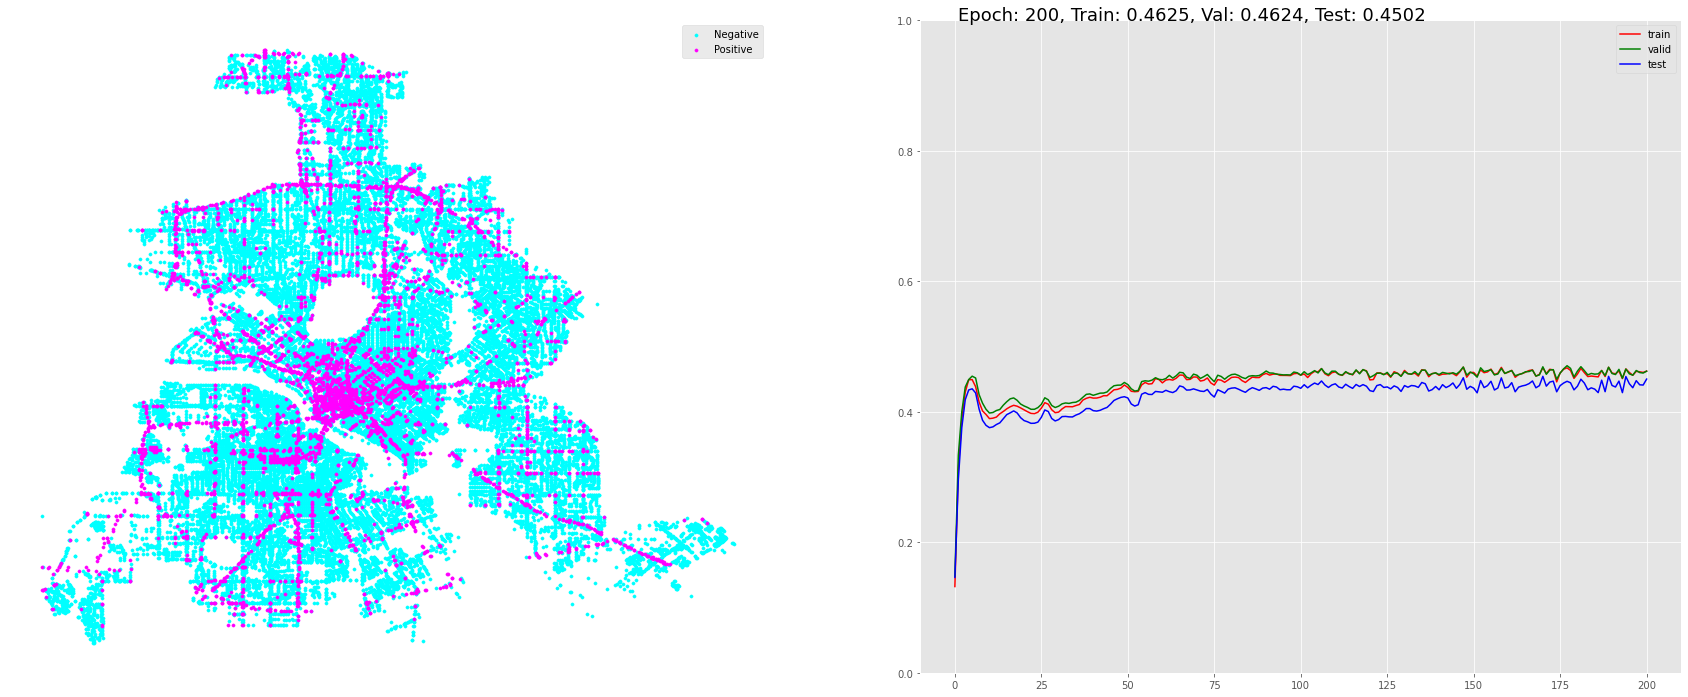

Selected epoch 177
F measure 0.44688 | Test Accuracy 0.75517 | MAP 0.60937 | AUC 0.75581


In [29]:
class ChebNet(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(ChebNet, self).__init__()
        self.conv1 = pyg_nn.ChebConv(dataset.num_features, hidden_dim, K=2)
        self.conv2 = pyg_nn.ChebConv(hidden_dim, 32, K=2)
        self.fc1 = nn.Linear(32, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr[:,0]
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
model = ChebNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('ChebNet',) + res)

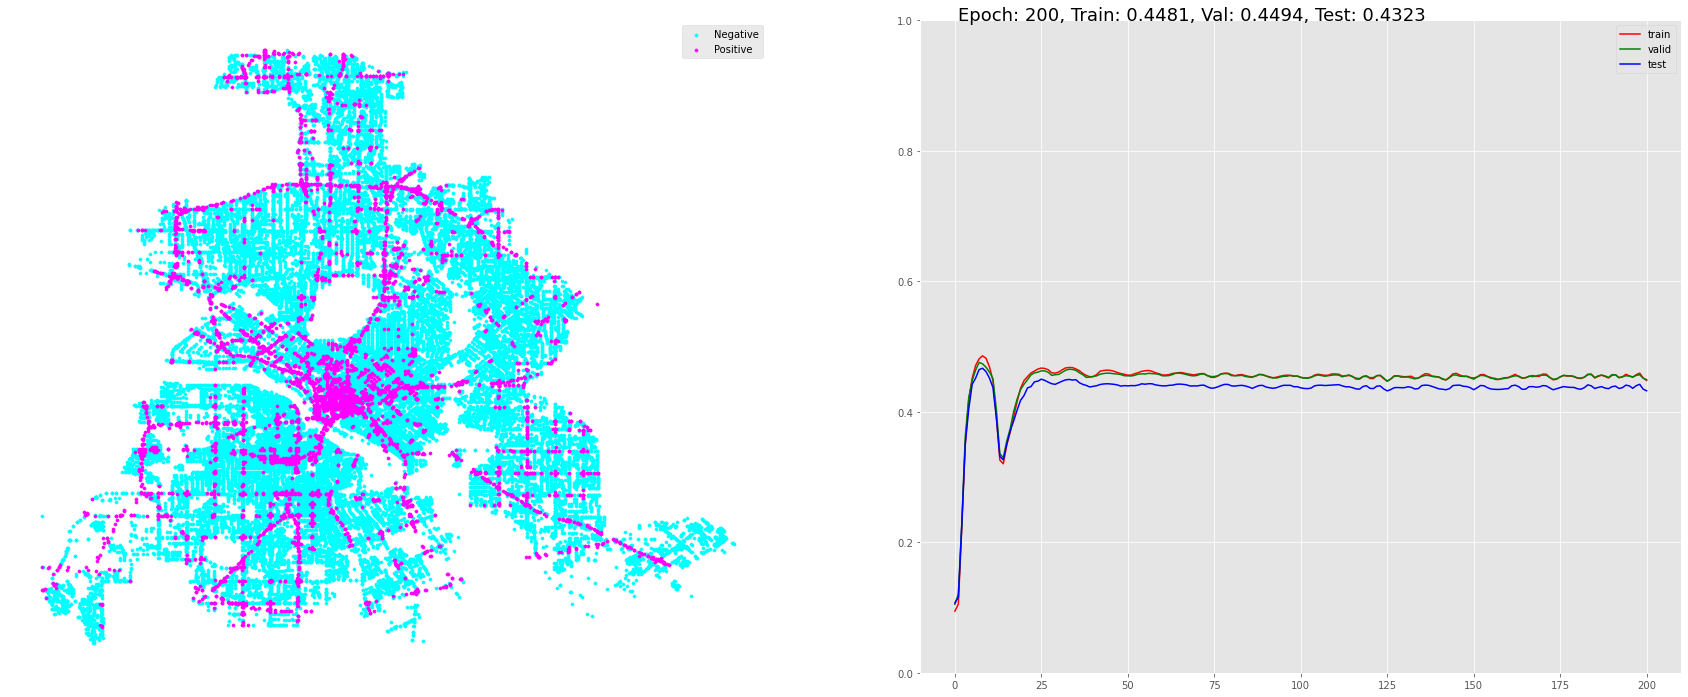

Selected epoch 184
F measure 0.43990 | Test Accuracy 0.74532 | MAP 0.57267 | AUC 0.73199


In [30]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr[:,0]
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs)
all_res.append(('GCN',) + res)

In [31]:
results = pd.DataFrame(all_res, columns=['Method', 'F1', 'Accuracy', 'MAP', 'AUC'])
results

,Method,F1,Accuracy,MAP,AUC
0,XGBoost,0.315368,0.739215,0.397700,0.586605
1,MLP,0.309838,0.739215,0.475876,0.683208
2,SAGENet,0.448156,0.757109,0.606645,0.756776
3,GAT,0.441631,0.749202,0.572841,0.731355
4,MPNN,0.507380,0.680538,0.519221,0.693958
5,GMMNet,0.315253,0.739076,0.475853,0.683119
6,GINE,0.486672,0.751561,0.608408,0.761628
7,TRAVEL,0.623227,0.782633,0.689456,0.823338
8,ChebNet,0.446882,0.755167,0.609372,0.755807
9,GCN,0.439902,0.745318,0.572669,0.731993
